In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import (
    roc_curve, precision_recall_curve, auc
)
import numpy as np

def run_modeling_pipeline_from_csv(fold_numbers, label_col='Same_Complex'):
    """
    Trains Logistic Regression, SVM, and Random Forest across precomputed CSV folds
    and plots ROC + PR curves.

    Parameters:
        fold_numbers (List[int]): List of fold identifiers (e.g., [1, 2, 3, 4, 5]).
        label_col (str): Name of the label column in the CSV files.

    File format assumption:
        - For fold i:
            - X_y_train_i.csv
            - X_y_test_i.csv
        - Each CSV contains feature columns and a 'Label' column.
    """

    # --- Triangle Correlation Plot Section ---
    # d = pd.read_csv('balanced_fold_1.csv').drop(columns=[label_col, 'global_index', 'Test', 'Unnamed: 0', 'scGPT_CP_embeddings_Cosine_Similarity'])
    # cols = list(d.columns)
    # print(cols)
    # data = pd.DataFrame(columns=cols)
    
    # print('Starting triangle corr plot')
    # for i in fold_numbers:
    #     data_ = pd.read_csv(f'balanced_fold_{i}.csv').drop(columns=[label_col, 'global_index', 'Test', 'Unnamed: 0', 'scGPT_CP_embeddings_Cosine_Similarity'])
    #     data = pd.concat([data, data_])
        
    #     #display(data)
    #     # train_df = data[data['Test']==False].drop(columns=[
    #     # train_df = pd.read_csv(f"X_y_train_{i}.csv").drop(columns=[label_col])
    #     # test_df = pd.read_csv(f"X_y_test_{i}.csv").drop(columns=[label_col])
    #     # # all_X.append(train_df)
    #     # # all_X.append(test_df)

    #     # merged_X = pd.concat([train_df, test_df], axis=0)

    # data = data.dropna()
    
    # display(data)
    #     # Compute correlation matrix
    # corr = data.corr()
    
    #     # Mask the upper triangle
    # mask = np.triu(np.ones_like(corr, dtype=bool))
    
    #     # Plot
    # plt.figure(figsize=(12, 10))
    # sns.heatmap(
    #         corr,
    #         mask=mask,
    #         cmap='coolwarm',
    #         center=0,
    #         annot=True,
    #         fmt=".2f",
    #         square=True,
    #         linewidths=0.5,
    #         cbar_kws={"shrink": 0.75}
    # )
    # plt.title(f"Feature Correlation Heatmap (Lower Triangle Only)", fontsize=14)
    # plt.tight_layout()
    # plt.savefig('correlation_heatmap.png', dpi=300)
    # plt.show()

        
    print("Starting logsitic regression, SVM and random forest")
    
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "SVM": SVC(probability=True),
        "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=-1)
    }

    model_results = pd.DataFrame()
    
    for model_name, model in models.items():

        print(f"Running {model_name}")
        plt.figure(figsize=(12, 5))

        roc = []
        pr = []

        # ROC Curve
        plt.subplot(1, 2, 1)
        for i in fold_numbers:
            #data = pd.read_csv(f'balanced_fold_{i}.csv').drop(columns=['global_index', 'Unnamed: 0', 'scGPT_CP_embeddings_Cosine_Similarity']).dropna()
            data = pd.read_csv(f'balanced_fixed-test_fold_{i}.csv').drop(columns=['global_index', 'Unnamed: 0', 'scGPT_CP_embeddings_Cosine_Similarity']).dropna()
            train_df = data[data['Test']==False].drop(columns=['Test'])
            test_df = data[data['Test']==True].drop(columns=['Test'])

            X_train = train_df.drop(columns=[label_col])
            y_train = train_df[label_col]
            X_test = test_df.drop(columns=[label_col])
            y_test = test_df[label_col]

            model.fit(X_train, y_train)
            y_score = model.predict_proba(X_test)[:, 1]

            fpr, tpr, _ = roc_curve(y_test, y_score)
            roc_auc = auc(fpr, tpr)
            roc.append(roc_auc)
            plt.plot(fpr, tpr, lw=2, label=f"Fold {i} (AUC = {roc_auc:.2f})")

        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.title(f"{model_name} - ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()

        # PR Curve
        plt.subplot(1, 2, 2)
        for i in fold_numbers:
            #data = pd.read_csv(f'balanced_fold_{i}.csv').drop(columns=['global_index', 'Unnamed: 0', 'scGPT_CP_embeddings_Cosine_Similarity']).dropna()
            data = pd.read_csv(f'balanced_fixed-test_fold_{i}.csv').drop(columns=['global_index', 'Unnamed: 0', 'scGPT_CP_embeddings_Cosine_Similarity']).dropna()
            train_df = data[data['Test']==False].drop(columns=['Test'])
            test_df = data[data['Test']==True].drop(columns=['Test'])

            X_train = train_df.drop(columns=[label_col])
            y_train = train_df[label_col]
            X_test = test_df.drop(columns=[label_col])
            y_test = test_df[label_col]

            model.fit(X_train, y_train)
            y_score = model.predict_proba(X_test)[:, 1]

            precision, recall, _ = precision_recall_curve(y_test, y_score)
            pr_auc = auc(recall, precision)
            pr.append(pr_auc)
            plt.plot(recall, precision, lw=2, label=f"Fold {i} (AUC = {pr_auc:.2f})")

        model_results[f'{model_name}_AUROC_per_fold'] = roc
        model_results[f'{model_name}_AUPRC_per_fold'] = pr

        plt.title(f"{model_name} - Precision-Recall Curve")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.legend()

        plt.tight_layout()
        plt.savefig(f"{model_name}_all_features_cs_roc_pr_fixed-test-set.png", dpi=300)
        plt.show()

    display(model_results)

    model_results = model_results.reset_index()
    model_results.rename(columns={'index':'Fold'},inplace=True)
    model_results.to_csv('all_features_cosine_similarity_model_results_balanced_5foldCV_fixed-test-set.csv', index=False)


Starting logsitic regression, SVM and random forest
Running Logistic Regression


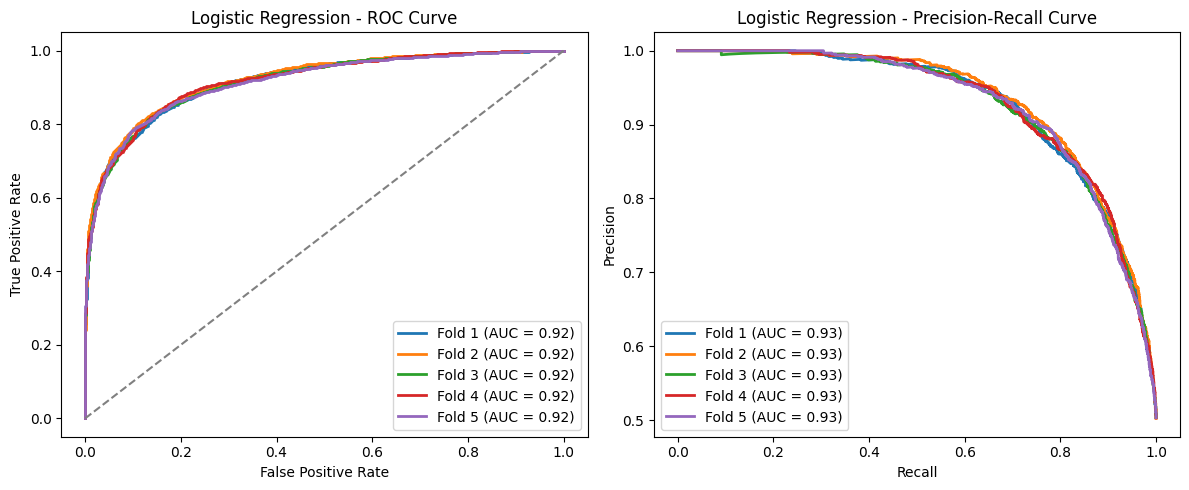

Running SVM


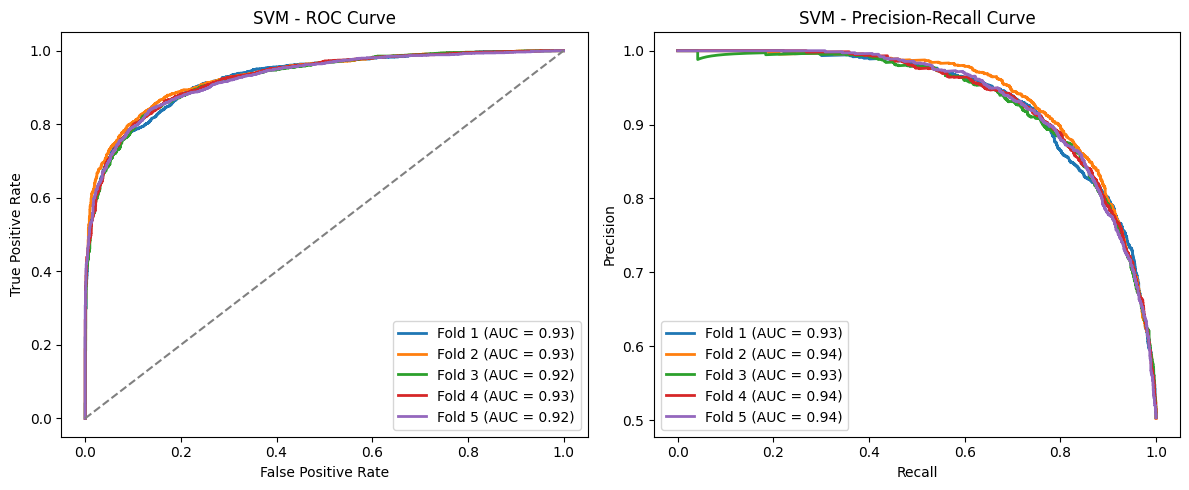

Running Random Forest


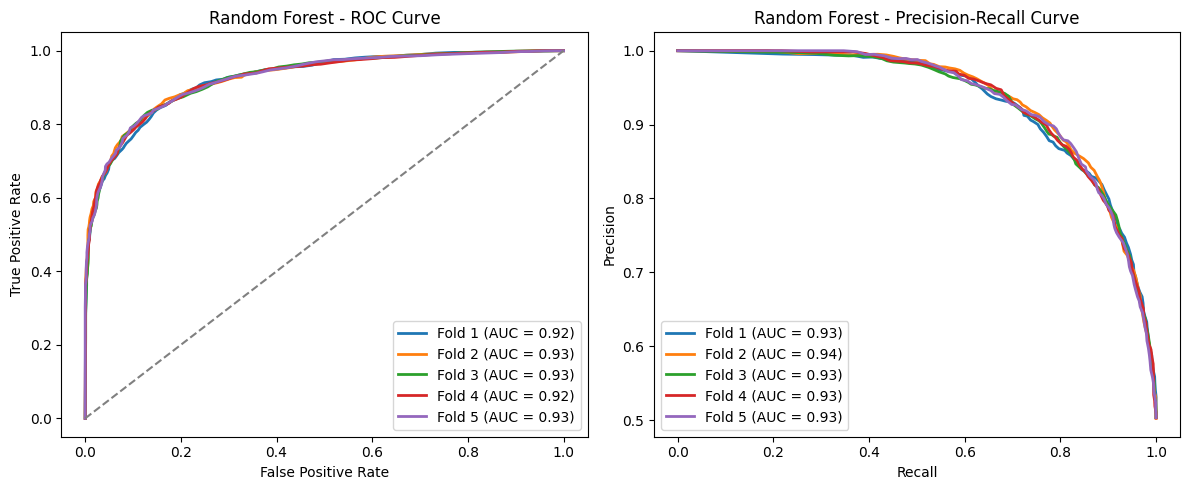

,Logistic Regression_AUROC_per_fold,Logistic Regression_AUPRC_per_fold,SVM_AUROC_per_fold,SVM_AUPRC_per_fold,Random Forest_AUROC_per_fold,Random Forest_AUPRC_per_fold
0,0.917496,0.928740,0.926033,0.934856,0.924369,0.932896
1,0.922525,0.933290,0.930748,0.940575,0.926411,0.936517
2,0.916340,0.927331,0.924474,0.932674,0.925026,0.932716
3,0.917941,0.929205,0.926131,0.935517,0.924408,0.934429
4,0.915184,0.927688,0.924802,0.935679,0.925009,0.934693


In [40]:
run_modeling_pipeline_from_csv(fold_numbers=[1, 2, 3, 4, 5])

# Running now with fixed test set

Starting logsitic regression, SVM and random forest
Running Logistic Regression


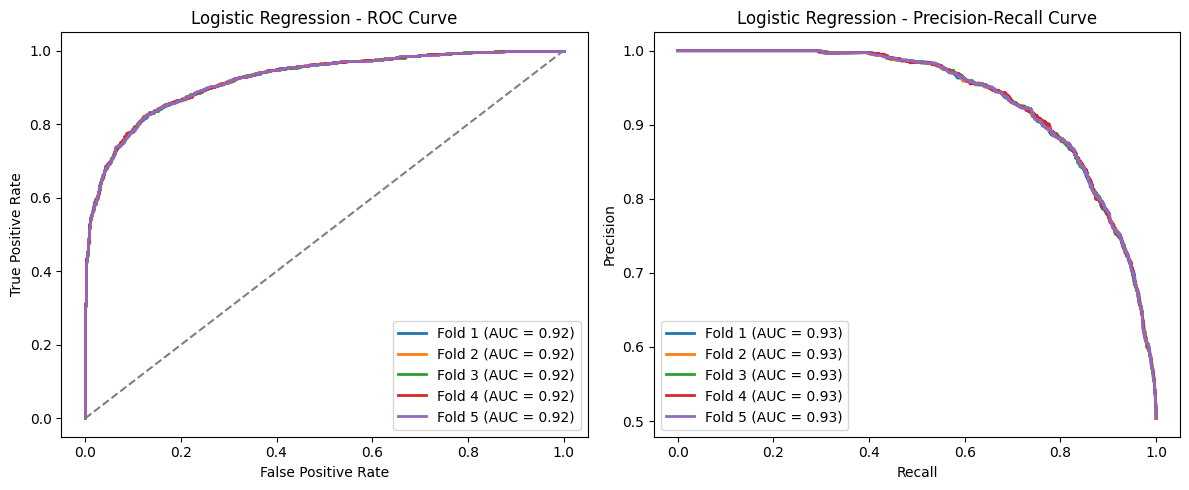

Running SVM


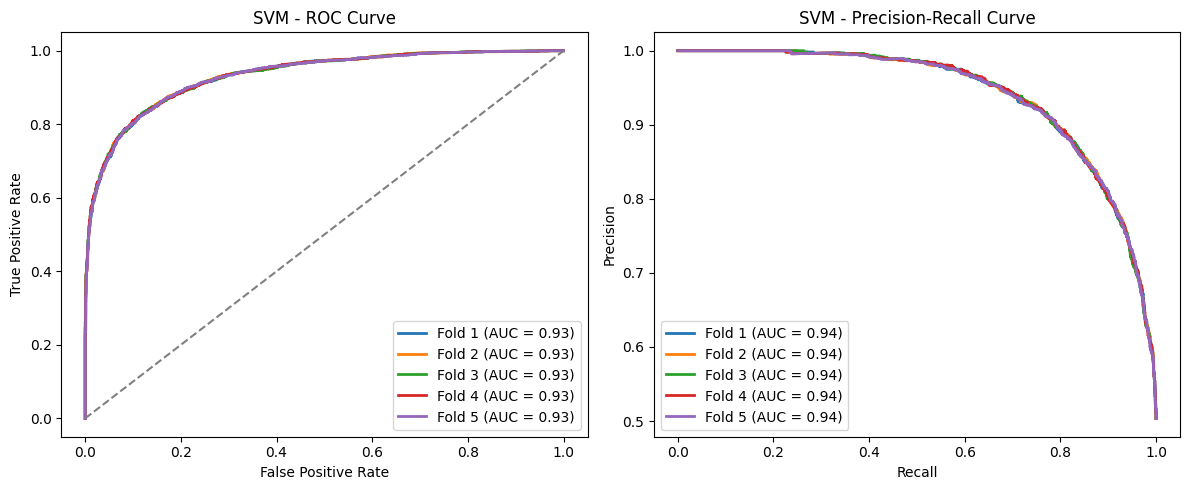

Running Random Forest


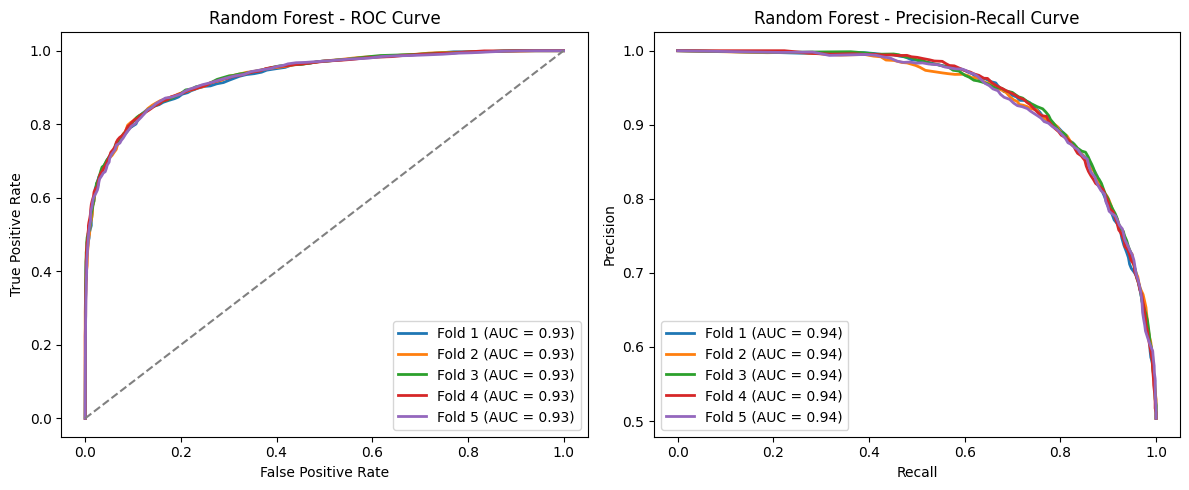

,Logistic Regression_AUROC_per_fold,Logistic Regression_AUPRC_per_fold,SVM_AUROC_per_fold,SVM_AUPRC_per_fold,Random Forest_AUROC_per_fold,Random Forest_AUPRC_per_fold
0,0.923003,0.934050,0.931723,0.940124,0.928575,0.939010
1,0.923294,0.934173,0.931922,0.940214,0.930331,0.937455
2,0.922912,0.934197,0.931546,0.940394,0.930887,0.940158
3,0.923218,0.934407,0.931776,0.940306,0.930328,0.939251
4,0.922921,0.934099,0.931342,0.939724,0.929123,0.937198


In [43]:
run_modeling_pipeline_from_csv(fold_numbers=[1, 2, 3, 4, 5])

In [ ]:
run_modeling_pipeline_from_csv(fold_numbers=[1, 2, 3, 4, 5])

In [15]:
!ls

Untitled.ipynb	X_y_test_3.csv	X_y_train_1.csv  X_y_train_4.csv
X_y_test_1.csv	X_y_test_4.csv	X_y_train_2.csv  X_y_train_5.csv
X_y_test_2.csv	X_y_test_5.csv	X_y_train_3.csv


In [57]:
train = pd.read_csv('X_y_train_1.csv')
test = pd.read_csv('X_y_test_1.csv')

In [58]:
train

,Unnamed: 0,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_Cosine_Similarity,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,scGPT_brain_embeddings_Cosine_Similarity,scGPT_kidney_embeddings_Cosine_Similarity,scGPT_human_embeddings_Cosine_Similarity,GF-6L30M_HUMANemb_Cosine_Similarity,...,GF-6L30M_HUMANemb_Cosine_Similarity.1,GF-20L95M_HUMANemb_Cosine_Similarity.1,GF-12L95M_HUMANemb_Cosine_Similarity.1,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity.1,GF-12L30M_HUMANemb_Cosine_Similarity.1,Correlation,Unnamed: 0.1,index,GeneAB,Same_Complex
0,953414,0.013358,0.132380,0.034187,-0.021754,-0.017664,-0.105123,-0.067042,0.034699,0.447293,...,0.447293,0.309971,0.842302,0.853994,0.788279,-0.006084,281604,1233514,SMC4_NCAPH,1
1,954646,0.069726,0.083560,-0.061505,0.023533,0.036056,0.075536,-0.012963,-0.059934,0.401507,...,0.401507,0.240476,0.763576,0.796528,0.722849,0.221871,284833,1236971,SMC4_NCAPD2,1
2,1001417,0.058907,0.145817,0.108491,0.015090,0.056979,0.241465,0.017986,0.109949,0.482511,...,0.482511,0.253609,0.849937,0.837114,0.727190,0.031073,285946,1238154,SMC4_NCAPG,1
3,1012540,-0.032935,0.075101,0.044762,0.035776,0.008265,-0.092496,0.044854,0.044567,0.228114,...,0.228114,0.141486,0.783905,0.843826,0.839535,0.214756,295917,1248692,SMC4_SMC2,1
4,1037328,0.071488,0.050454,-0.009826,0.027153,0.019830,-0.019027,0.006608,-0.009995,0.389317,...,0.389317,0.086838,0.803960,0.865950,0.845771,0.529243,709474,1704555,PSMD4_PSMD13,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16467,200675973,0.047576,0.078914,0.194738,-0.000402,-0.021814,0.282966,0.005132,0.194905,0.787091,...,0.787091,0.118593,0.819660,0.876838,0.916024,NaN,73788962,84503432,ZNF532_KBTBD4,0
16468,200708844,0.088620,0.095889,0.184965,0.134956,0.016124,0.154217,0.095091,0.184813,0.361977,...,0.361977,0.172202,0.674702,0.793354,0.647375,NaN,122991118,140116187,RAD21L1_CHST14,0
16469,200719375,0.001766,0.100528,0.069150,-0.022134,0.025309,0.115316,-0.018439,0.070124,0.236251,...,0.236251,0.119413,0.744725,0.800108,0.772759,NaN,73599402,84274840,BCAP31_COX7A2L,0
16470,200742011,-0.035334,-0.008334,0.206594,-0.011380,-0.024317,0.399726,-0.002707,0.207447,0.365510,...,0.365510,0.321938,0.668598,0.659472,0.445524,NaN,49051153,56420031,KRT25_NMT2,0


In [71]:
scgpt_human[scgpt_human['Cosine_Similarity']<=0.99]['Cosine_Similarity'].describe()

count    2.007945e+08
mean     6.028477e-02
std      9.004868e-02
min     -3.571481e-01
25%     -4.329214e-03
50%      5.402928e-02
75%      1.186591e-01
max      8.923230e-01
Name: Cosine_Similarity, dtype: float64

In [52]:
train = train[train['scGPT_human_embeddings_Cosine_Similarity']<=0.99]
train1 = train[train['Same_Complex']==1]
train0 = train[train['Same_Complex']==0]

<Axes: >

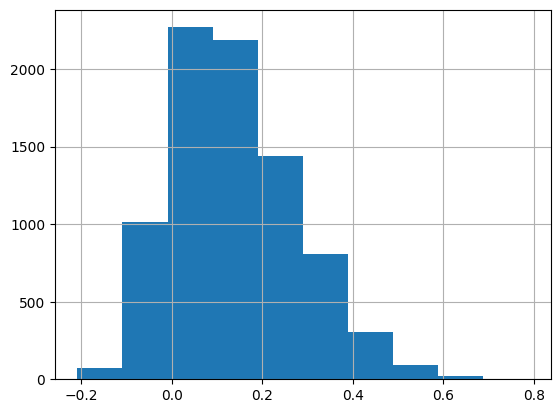

In [53]:
train1['scGPT_human_embeddings_Cosine_Similarity'].hist()

In [56]:
train1['scGPT_human_embeddings_Cosine_Similarity'].mean()

0.13943374586988938

<Axes: >

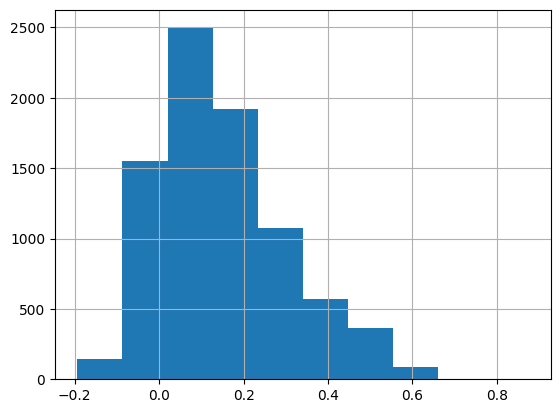

In [54]:
train0['scGPT_human_embeddings_Cosine_Similarity'].hist()

In [55]:
train0['scGPT_human_embeddings_Cosine_Similarity'].mean()

0.14939931181232916

In [25]:
scgpt_human = pd.read_pickle('/home/ubuntu/scgpt_split_outputs/scGPT_human_embeddings_similarities_similarity_only.pkl')
gp = pd.read_pickle('/home/ubuntu/scgpt_split_outputs/gene_pairs.pkl')
scgpt_human = pd.concat([scgpt_human, gp], axis=1)
scgpt_human

,Cosine_Similarity,Gene_A,Gene_B
0,0.357125,ST13P4,WASH2P
1,0.106240,ST13P4,FAM90A12P
2,0.160441,ST13P4,PI4KAP1
3,0.211458,ST13P4,SNX29P2
4,0.100117,ST13P4,ZNF818P
...,...,...,...
200794870,-0.122569,RBMXP1,PPT1
200794871,0.069859,RBMXP1,PLD2
200794872,-0.037521,RBMXP1,EIF4EBP1
200794873,0.135589,RBMXP1,TINAG


In [27]:
scgpt_human['GeneAB'] = scgpt_human['Gene_A'] + '_' + scgpt_human['Gene_B']
scgpt_human.drop(columns=['Gene_A', 'Gene_B'], inplace=True)

In [59]:
scgpt_human.iloc[200766268]

Cosine_Similarity      -0.028998
GeneAB               TINAG_UHMK1
Name: 200766268, dtype: object

In [62]:
train.columns = ['index_og', 'scGPT_bc_embeddings_Cosine_Similarity',
       'scGPT_pancancer_embeddings_Cosine_Similarity',
       'scGPT_CP_embeddings_Cosine_Similarity',
       'scGPT_lung_embeddings_Cosine_Similarity',
       'scGPT_heart_embeddings_Cosine_Similarity',
       'scGPT_brain_embeddings_Cosine_Similarity',
       'scGPT_kidney_embeddings_Cosine_Similarity',
       'scGPT_human_embeddings_Cosine_Similarity',
       'GF-6L30M_HUMANemb_Cosine_Similarity',
       'GF-20L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity',
       'GF-12L30M_HUMANemb_Cosine_Similarity',
       'GF-6L30M_HUMANemb_Cosine_Similarity.1',
       'GF-20L95M_HUMANemb_Cosine_Similarity.1',
       'GF-12L95M_HUMANemb_Cosine_Similarity.1',
       'GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity.1',
       'GF-12L30M_HUMANemb_Cosine_Similarity.1', 'Correlation', 'Unnamed: 0.1',
       'index', 'GeneAB', 'Same_Complex']

In [65]:
train_scgpt = train[['index_og', 'scGPT_bc_embeddings_Cosine_Similarity',
       'scGPT_pancancer_embeddings_Cosine_Similarity',
       'scGPT_CP_embeddings_Cosine_Similarity',
       'scGPT_lung_embeddings_Cosine_Similarity',
       'scGPT_heart_embeddings_Cosine_Similarity',
       'scGPT_brain_embeddings_Cosine_Similarity',
       'scGPT_kidney_embeddings_Cosine_Similarity',
       'scGPT_human_embeddings_Cosine_Similarity']]

In [67]:
train

,index_og,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_Cosine_Similarity,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,scGPT_brain_embeddings_Cosine_Similarity,scGPT_kidney_embeddings_Cosine_Similarity,scGPT_human_embeddings_Cosine_Similarity,GF-6L30M_HUMANemb_Cosine_Similarity,...,GF-6L30M_HUMANemb_Cosine_Similarity.1,GF-20L95M_HUMANemb_Cosine_Similarity.1,GF-12L95M_HUMANemb_Cosine_Similarity.1,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity.1,GF-12L30M_HUMANemb_Cosine_Similarity.1,Correlation,Unnamed: 0.1,index,GeneAB,Same_Complex
0,953414,0.013358,0.132380,0.034187,-0.021754,-0.017664,-0.105123,-0.067042,0.034699,0.447293,...,0.447293,0.309971,0.842302,0.853994,0.788279,-0.006084,281604,1233514,SMC4_NCAPH,1
1,954646,0.069726,0.083560,-0.061505,0.023533,0.036056,0.075536,-0.012963,-0.059934,0.401507,...,0.401507,0.240476,0.763576,0.796528,0.722849,0.221871,284833,1236971,SMC4_NCAPD2,1
2,1001417,0.058907,0.145817,0.108491,0.015090,0.056979,0.241465,0.017986,0.109949,0.482511,...,0.482511,0.253609,0.849937,0.837114,0.727190,0.031073,285946,1238154,SMC4_NCAPG,1
3,1012540,-0.032935,0.075101,0.044762,0.035776,0.008265,-0.092496,0.044854,0.044567,0.228114,...,0.228114,0.141486,0.783905,0.843826,0.839535,0.214756,295917,1248692,SMC4_SMC2,1
4,1037328,0.071488,0.050454,-0.009826,0.027153,0.019830,-0.019027,0.006608,-0.009995,0.389317,...,0.389317,0.086838,0.803960,0.865950,0.845771,0.529243,709474,1704555,PSMD4_PSMD13,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16467,200675973,0.047576,0.078914,0.194738,-0.000402,-0.021814,0.282966,0.005132,0.194905,0.787091,...,0.787091,0.118593,0.819660,0.876838,0.916024,NaN,73788962,84503432,ZNF532_KBTBD4,0
16468,200708844,0.088620,0.095889,0.184965,0.134956,0.016124,0.154217,0.095091,0.184813,0.361977,...,0.361977,0.172202,0.674702,0.793354,0.647375,NaN,122991118,140116187,RAD21L1_CHST14,0
16469,200719375,0.001766,0.100528,0.069150,-0.022134,0.025309,0.115316,-0.018439,0.070124,0.236251,...,0.236251,0.119413,0.744725,0.800108,0.772759,NaN,73599402,84274840,BCAP31_COX7A2L,0
16470,200742011,-0.035334,-0.008334,0.206594,-0.011380,-0.024317,0.399726,-0.002707,0.207447,0.365510,...,0.365510,0.321938,0.668598,0.659472,0.445524,NaN,49051153,56420031,KRT25_NMT2,0


In [64]:
train[train['index_og']==200766268]

,index_og,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_Cosine_Similarity,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,scGPT_brain_embeddings_Cosine_Similarity,scGPT_kidney_embeddings_Cosine_Similarity,scGPT_human_embeddings_Cosine_Similarity,GF-6L30M_HUMANemb_Cosine_Similarity,...,GF-6L30M_HUMANemb_Cosine_Similarity.1,GF-20L95M_HUMANemb_Cosine_Similarity.1,GF-12L95M_HUMANemb_Cosine_Similarity.1,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity.1,GF-12L30M_HUMANemb_Cosine_Similarity.1,Correlation,Unnamed: 0.1,index,GeneAB,Same_Complex
16471,200766268,-0.022234,0.083485,-0.046064,-0.011263,-0.000442,-0.004302,-0.015539,-0.028998,0.408887,...,0.408887,0.171643,0.792192,0.820509,0.772606,NaN,139145256,158606264,CCDC8_SPN,0


In [29]:
train_troubleshoot = train.merge(scgpt_human, on = 'GeneAB')

In [31]:
train_troubleshoot[['scGPT_human_embeddings_Cosine_Similarity', 'Cosine_Similarity']]

,scGPT_human_embeddings_Cosine_Similarity,Cosine_Similarity
0,0.034699,0.278526
1,-0.059934,0.342933
2,0.109949,0.390422
3,0.044567,0.454553
4,-0.009995,0.417977
...,...,...
16467,0.194905,-0.069396
16468,0.184813,0.183922
16469,0.070124,0.155701
16470,0.207447,-0.028151


In [34]:
test_troubleshoot = test.merge(scgpt_human, on = 'GeneAB')

In [35]:
test_troubleshoot[['scGPT_human_embeddings_Cosine_Similarity', 'Cosine_Similarity']]

,scGPT_human_embeddings_Cosine_Similarity,Cosine_Similarity
0,0.044449,0.380412
1,-0.025855,0.387813
2,0.069371,0.355155
3,0.033088,0.347643
4,-0.053172,0.324181
...,...,...
4115,0.212773,0.058331
4116,0.230775,0.123375
4117,0.148919,0.071515
4118,0.187529,0.070990


In [41]:
troubleshoot = pd.concat([train_troubleshoot, test_troubleshoot])
troubleshoot = troubleshoot[troubleshoot['Cosine_Similarity']<=0.99]

In [42]:
troubleshoot1=troubleshoot[troubleshoot['Same_Complex']==1]
troubleshoot0=troubleshoot[troubleshoot['Same_Complex']==0]

<Axes: >

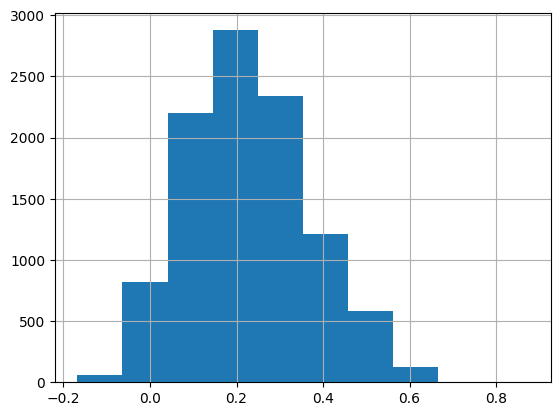

In [43]:
troubleshoot1['Cosine_Similarity'].hist()

In [44]:
troubleshoot1['Cosine_Similarity'].mean()

0.22845280951867566

<Axes: >

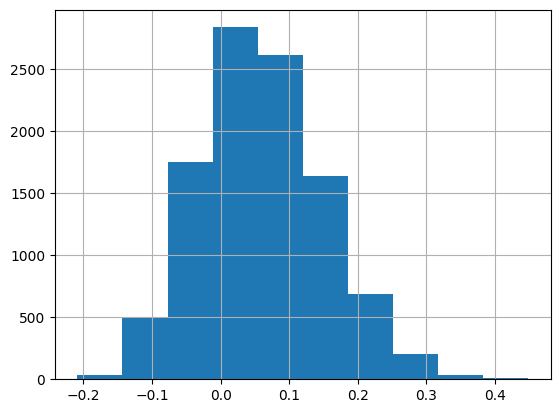

In [45]:
troubleshoot0['Cosine_Similarity'].hist()

In [46]:
troubleshoot0['Cosine_Similarity'].mean()

0.06023483573709673